In [1]:
from torch.utils.data import DataLoader, random_split,TensorDataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import NN_classes
from torchvision import datasets, transforms
import training_methods
import DataLoading
import pivottablejs
import math
%matplotlib inline

In [2]:
#executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]
#executions = ["Network_Line_Out_N_101_N_102_cac1"]
#executions = ["Network_Full_Generation_Full","Network_Line_In_N_101_N_102_cac1","Network_Line_In_N_101_N_103_cac1","Network_Line_In_N_101_N_105_cac1"]

executions = ["Network_Existing_Generation_Full"]
sc = "sc01"
period = "2030"
folder = "Samples_3-bus_ACOPF"
te_s = 0.1
val_s = 0.2

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

Data/input_f_sc01_Network_Existing_Generation_Full_2030.csv
23


In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te(dfs_in,dfs_out,executions,te_s,val_s)

In [5]:
d_ft_in, d_ft_out = DataLoading.concat_and_normalize(ts_in,ts_out,executions)

In [6]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=32)
validation_loader = DataLoader(train,batch_size=32)

In [11]:
def create_model(nb_hidden,input_size,nb_neurons = (0,0),dor = None):
    if dor is None: 
        if nb_hidden == 0: 
            m = NN_classes.ObjectiveEstimator_ANN_Single_layer(input_size=input_size,output_size=1)  
        elif nb_hidden == 1: 
            hs1 = int(math.sqrt(d_ft_in['train'].shape[1]))
            m = NN_classes.ObjectiveEstimator_ANN_1hidden_layer(input_size=input_size,hidden_size1=hs1,output_size=1)  
        elif nb_hidden == 2: 
            hs1 = int(math.sqrt(d_ft_in['train'].shape[1]))
            hs2 = int(math.sqrt(math.sqrt(d_ft_in['train'].shape[1])))
            m = NN_classes.ObjectiveEstimator_ANN_2hidden_layer(input_size=input_size,hidden_size1=hs1,hidden_size2=hs2,output_size=1)
        elif nb_hidden == 3:
            hs1 = int(d_ft_in['train'].shape[1]/4)
            hs2 = int(d_ft_in['train'].shape[1]/16)
            hs3 = int(d_ft_in['train'].shape[1]/64)
            m = NN_classes.ObjectiveEstimator_ANN_3hidden_layer(input_size=input_size,hidden_size1=hs1,hidden_size2=hs2,hidden_size3=hs3,output_size=1)
    else: 
        if nb_hidden == 0: 
            m = NN_classes.ObjectiveEstimator_ANN_Single_layer_dropout(input_size=input_size,output_size=1,do_r=dor)
    return m

In [26]:
learning_rates = [0.01*4**i for i in range(3)]
loss_fn = torch.nn.MSELoss()
nbs_e = [1,2,4,8]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            m = create_model(nb_hidden,input_size=d_ft_in['train'].shape[1])
            m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
            optimizer = torch.optim.Adam(m.parameters(), lr=lr)
            train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,True)
            
            saved_models = dict()
            
            for mt in ["min_val","all_epochs"]:
                path = f"trained_models/{mt}/model_{m_name}.pth"

                
                model = m
                m.load_state_dict(torch.load(path))
                m.eval()

                test_predictions = m(d_ft_in["test"].float())
                test_loss = loss_fn(test_predictions,d_ft_out["test"])
                
                train_predictions = m(d_ft_in["train"].float())
                train_loss = loss_fn(train_predictions,d_ft_out["train"])
                
                validation_prediction = m(d_ft_in["val"].float())
                validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                if mt == "min_val": 
                    min_val = True
                else: 
                    min_val = False

                r = pd.DataFrame({"Model_type": nb_hidden,"Min_val":min_val,"Epochs": nb_e,"Lr":lr, "Tr_l":train_loss.item(),"Te_l":test_loss.item(),"V_l": validation_loss.item()},index = [i]
                )
                i+=1
                results = pd.concat([results,r])

EPOCH 1:
  batch 1 loss: 4.6571502462029454e-05
  batch 101 loss: 0.0013790533083374611
LOSS train 0.0009055268209646834 valid 0.00044891759171150625


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([874])) that is different to the input size (torch.Size([874, 1])). This will likely lead to incorrect results due to broadcasting. Please en

EPOCH 1:
  batch 1 loss: 0.0020991817116737367
  batch 101 loss: 0.0050303048756723005
LOSS train 0.003632892649771554 valid 3.5523600672604516e-05
EPOCH 1:
  batch 1 loss: 0.006295127868652344
  batch 101 loss: 0.08536954214301659
LOSS train 0.04653927889799926 valid 3.754870192551607e-08


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


EPOCH 1:
  batch 1 loss: 7.598357001370459e-09
  batch 101 loss: 3.5267525583027036e-06
LOSS train 1.8042565276598634e-06 valid 1.8270878854309558e-07
EPOCH 1:
  batch 1 loss: 0.0010562753677368164
  batch 101 loss: 0.014466171069943811
LOSS train 0.008082097207892184 valid 0.00016070675337687135
EPOCH 1:
  batch 1 loss: 0.0003597838431596756
  batch 101 loss: 0.002460116074262686
LOSS train 0.0014314965425196806 valid 1.7237061911146156e-07
EPOCH 1:
  batch 1 loss: 0.002504109740257263
  batch 101 loss: 0.00394940465926993
LOSS train 0.0033241374578007387 valid 5.515299199032597e-05
EPOCH 1:
  batch 1 loss: 7.598357001370459e-09
  batch 101 loss: 6.484566458188068e-05
LOSS train 3.2936733340913424e-05 valid 1.6291983229166362e-07
EPOCH 1:
  batch 1 loss: 0.002084341496229172
  batch 101 loss: 0.35659139283001423
LOSS train 0.18220902406612025 valid 0.00014486690633930266
EPOCH 1:
  batch 1 loss: 0.00016869259998202323
  batch 101 loss: 0.0797567473975251
LOSS train 0.04057172538651087

LOSS train 2.1518383832834224e-08 valid 4.3677069072600716e-08
EPOCH 4:
  batch 1 loss: 1.913203462322599e-10
  batch 101 loss: 2.287202172990277e-08
LOSS train 2.1557330750718996e-08 valid 3.2497965207767265e-08
EPOCH 1:
  batch 1 loss: 0.0021690888702869415
  batch 101 loss: 0.009300816231215023
LOSS train 0.005822435271660535 valid 2.7139861913383356e-08
EPOCH 2:
  batch 1 loss: 7.038093663425116e-11
  batch 101 loss: 2.7964256030799108e-08
LOSS train 2.1826460987146117e-08 valid 2.7273092229052054e-08
EPOCH 3:
  batch 1 loss: 7.307580318638429e-11
  batch 101 loss: 2.8143514234635347e-08
LOSS train 2.4432591773786832e-08 valid 2.8482871172741397e-08
EPOCH 4:
  batch 1 loss: 6.758150039587463e-11
  batch 101 loss: 2.573443075526427e-08
LOSS train 2.4069375255447074e-08 valid 4.666154396204547e-08
EPOCH 1:
  batch 1 loss: 7.598357001370459e-09
  batch 101 loss: 6.484566458188068e-05
LOSS train 3.2936733340913424e-05 valid 1.6291983229166362e-07
EPOCH 2:
  batch 1 loss: 1.539195011446

LOSS train 9.876818862380644e-08 valid 2.9021140335316886e-07
EPOCH 7:
  batch 1 loss: 2.857171921277768e-09
  batch 101 loss: 1.3596063913601242e-07
LOSS train 1.4475787920074338e-07 valid 1.757144474368033e-07
EPOCH 8:
  batch 1 loss: 1.6724354168218268e-09
  batch 101 loss: 2.5508923273687145e-07
LOSS train 2.0523051534132445e-07 valid 1.2188803566459683e-07
EPOCH 1:
  batch 1 loss: 0.0035133010149002077
  batch 101 loss: 0.013958273811804247
LOSS train 0.009219342395946913 valid 0.0005746094393543899
EPOCH 2:
  batch 1 loss: 2.502162242308259e-06
  batch 101 loss: 0.0006112236017725082
LOSS train 0.00034349810660729084 valid 4.918243575957604e-05
EPOCH 3:
  batch 1 loss: 4.892001015832647e-07
  batch 101 loss: 0.0001185668522089145
LOSS train 0.00018630168258403564 valid 0.00015554382116533816
EPOCH 4:
  batch 1 loss: 4.088390851393342e-06
  batch 101 loss: 0.0005243405637520482
LOSS train 0.0007706215257371119 valid 0.0008931743213906884
EPOCH 5:
  batch 1 loss: 1.60397298168391e-

LOSS train 3.1348523867012226e-08 valid 8.671942453020165e-08
EPOCH 7:
  batch 1 loss: 7.383974320873676e-10
  batch 101 loss: 4.78532554271105e-08
LOSS train 3.547618783060008e-08 valid 1.2761873335875862e-07
EPOCH 8:
  batch 1 loss: 1.1701207114356294e-09
  batch 101 loss: 5.679290262294856e-08
LOSS train 3.829038648925322e-08 valid 1.7089178072637878e-07
EPOCH 1:
  batch 1 loss: 7.598357001370459e-09
  batch 101 loss: 0.0010746598370171335
LOSS train 0.0005455558131975714 valid 1.551010342382142e-07
EPOCH 2:
  batch 1 loss: 1.457648011182755e-09
  batch 101 loss: 7.921439272973174e-08
LOSS train 5.5102622062501104e-08 valid 1.740781669923308e-07
EPOCH 3:
  batch 1 loss: 1.655409107570449e-09
  batch 101 loss: 9.318774020883324e-08
LOSS train 6.000231088637311e-08 valid 4.004807152568901e-08
EPOCH 4:
  batch 1 loss: 2.310797064808412e-10
  batch 101 loss: 1.584751797389927e-07
LOSS train 1.3084249057593987e-07 valid 5.937912561648773e-08
EPOCH 5:
  batch 1 loss: 4.448884283192456e-10

In [38]:
f = (results.Model_type == 0) &  (results.Min_val ==False) & (results.Epochs !=8)
results[f].boxplot(column = ["Te_l", "Tr_l","V_l"],by = ["dor"],layout = (3,1),sharey = False)

KeyError: 'dor'

In [39]:
learning_rates = [0.01*4**i for i in range(2)]
loss_fn = torch.nn.MSELoss()
nbs_e = [6]#,4,8]
i=0
nbs_hidden = [0]
dors = [None,0,0.2,0.4,0.6]
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = create_model(nb_hidden,d_ft_in['train'].shape[1],dor)
                if dor is None:
                    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
                else:                 
                    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,True)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions,d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions,d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

EPOCH 1:
  batch 1 loss: 0.0038035571575164794
  batch 101 loss: 0.013667512624961091


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.009400308943126967 valid 0.00186417275108397
EPOCH 2:
  batch 1 loss: 5.1709101535379885e-05
  batch 101 loss: 0.0010250554697267943
LOSS train 0.0007213617721570671 valid 0.0003256538475397974
EPOCH 3:
  batch 1 loss: 1.0036404710263014e-05
  batch 101 loss: 0.00034494912834816206
LOSS train 0.0002561983209982961 valid 0.0001011294370982796
EPOCH 4:
  batch 1 loss: 2.001771063078195e-06
  batch 101 loss: 0.00013385735032898083
LOSS train 0.00010164761680511597 valid 4.466002792469226e-05
EPOCH 5:
  batch 1 loss: 3.6963283491786567e-07
  batch 101 loss: 4.432829742654576e-05
LOSS train 3.3683990387154214e-05 valid 1.3112870874465443e-05
EPOCH 6:
  batch 1 loss: 2.586595110187773e-07
  batch 101 loss: 1.183692930851521e-05
LOSS train 8.55809655774631e-06 valid 2.6632019398675766e-06


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([874])) that is different to the input size (torch.Size([874, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([6289])) that is different to the input size (torch.Size([6289, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1573])) that is different to the input size (torch.Size([1573, 1])). This will likely lead to incorrect results due to broadcasting. P

EPOCH 1:
  batch 1 loss: 0.0025280815362930297
  batch 101 loss: 0.006121075835480951
LOSS train 0.004567627332375574 valid 0.0005244357162155211
EPOCH 2:
  batch 1 loss: 6.57816999591887e-06
  batch 101 loss: 0.0001134927920793416
LOSS train 0.00010672157611968268 valid 0.00029401297797448933
EPOCH 3:
  batch 1 loss: 2.487695892341435e-06
  batch 101 loss: 6.968760035306332e-05
LOSS train 6.956902177592794e-05 valid 0.0001237175747519359
EPOCH 4:
  batch 1 loss: 9.162959759123623e-07
  batch 101 loss: 3.7333458942612195e-05
LOSS train 3.902155037907007e-05 valid 7.477763574570417e-05
EPOCH 5:
  batch 1 loss: 8.546194294467568e-07
  batch 101 loss: 3.699844604625469e-05
LOSS train 3.394841876700776e-05 valid 2.667807348188944e-05
EPOCH 6:
  batch 1 loss: 2.650074202392716e-07
  batch 101 loss: 1.4129496828445553e-05
LOSS train 1.2387289968713505e-05 valid 1.0868719982681796e-05
EPOCH 1:
  batch 1 loss: 8.651137351989747e-05
  batch 101 loss: 0.0015278573525574757
LOSS train 0.000862392

0      True
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: Dor, dtype: bool

array([[<Axes: title={'center': 'Te_l'}, xlabel='[Min_val]'>,
        <Axes: title={'center': 'V_l'}, xlabel='[Min_val]'>],
       [<Axes: title={'center': 'Tr_l'}, xlabel='[Min_val]'>, <Axes: >]],
      dtype=object)

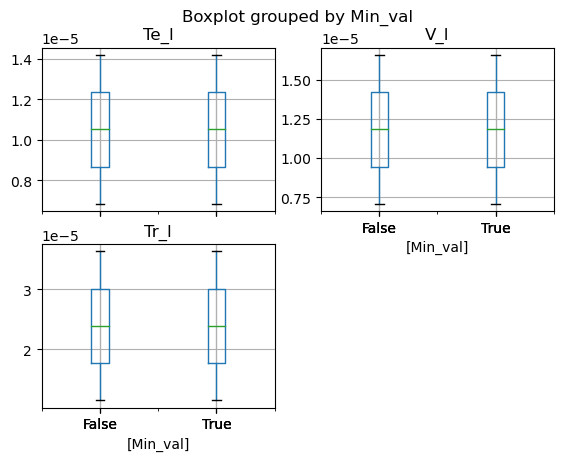

In [60]:
f = (results.Dor).isnull() |(results.Dor) == 0
results[f].boxplot(column = ["Te_l","V_l","Tr_l"],by = ["Min_val"],sharey = False)